In [2]:
# Importing libraries
import pandas as pd
from pathlib import Path
import requests
import json
import folium
from folium.plugins import HeatMap
import matplotlib.pyplot as plt

# Import the API key
from config import geoapify_key


In [3]:
# Importing data
censorship_data_csv = Path("Resources/Censorship_Data_by_Country.csv")
population_data_csv = Path("Resources/Country_Population_2023.csv")

# Reading data
censorship_data = pd.read_csv(censorship_data_csv)
population_data = pd.read_csv(population_data_csv)

In [4]:
# Inspecting data for Censorship
censorship_data.head()

,Flag,Country,Score,Torrents Restricted?,Torrents Banned or Shut Down?,Pornography Restricted?,Pornography Banned?,Political Media Restricted?,Political Media Heavily Censored?,Social Media Restricted?,Social Media Banned?,VPNs Restricted,VPNs Banned?,Messaging and VoIP App Restrictions
0,:af:,Afghanistan,6,Y,N,Y,Y,Y,Y,Y,N,N,N,N
1,:al:,Albania,2,Y,N,N,N,Y,N,N,N,N,N,N
2,:dz:,Algeria,5,Y,N,Y,N,Y,Y,Y,N,N,N,N
3,:ad:,Andorra,1,Y,N,N,N,N,N,N,N,N,N,N
4,:ao:,Angola,2,Y,N,N,N,Y,N,N,N,N,N,N


In [5]:
# Inspecting data for Population
population_data.head()

,#,Country (or dependency),Population (2023)
0,1,India,"1,428,627,663"
1,2,China,"1,425,671,352"
2,3,United States,"339,996,563"
3,4,Indonesia,"277,534,122"
4,5,Pakistan,"240,485,658"


In [6]:
# Cleaning and Renaming Population Data
population_data = population_data.rename(columns={"Country (or dependency)":"Country"})
population_data = population_data.rename(columns={"Population (2023)":"Population"})
population_data = population_data.drop(columns=["#"])
population_data.head()


,Country,Population
0,India,"1,428,627,663"
1,China,"1,425,671,352"
2,United States,"339,996,563"
3,Indonesia,"277,534,122"
4,Pakistan,"240,485,658"


In [29]:
# Merging Censorship and Population
censor_data_df = pd.merge(censorship_data, population_data, on="Country", how="left")
censor_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175 entries, 0 to 174
Data columns (total 15 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   Flag                                 174 non-null    object
 1   Country                              175 non-null    object
 2   Score                                175 non-null    int64 
 3   Torrents Restricted?                 175 non-null    object
 4   Torrents Banned or Shut Down?        175 non-null    object
 5   Pornography Restricted?              175 non-null    object
 6   Pornography Banned?                  175 non-null    object
 7   Political Media Restricted?          175 non-null    object
 8   Political Media Heavily Censored?    175 non-null    object
 9   Social Media Restricted?             175 non-null    object
 10  Social Media Banned?                 175 non-null    object
 11  VPNs Restricted                      175 non-

In [28]:
# Removed null values in the dataset
df_clean = censor_data_df.dropna()
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 165 entries, 0 to 174
Data columns (total 15 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   Flag                                 165 non-null    object
 1   Country                              165 non-null    object
 2   Score                                165 non-null    int64 
 3   Torrents Restricted?                 165 non-null    object
 4   Torrents Banned or Shut Down?        165 non-null    object
 5   Pornography Restricted?              165 non-null    object
 6   Pornography Banned?                  165 non-null    object
 7   Political Media Restricted?          165 non-null    object
 8   Political Media Heavily Censored?    165 non-null    object
 9   Social Media Restricted?             165 non-null    object
 10  Social Media Banned?                 165 non-null    object
 11  VPNs Restricted                      165 non-null 

In [26]:
# Extract Country into a list
country_list = list(df_clean["Country"])
print(country_list)


['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola', 'Argentina', 'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bahrain', 'Bangladesh', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Brunei', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia', 'Comoros', 'Costa Rica', 'Croatia', 'Cuba', 'Cyprus', 'Denmark', 'Djibouti', 'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia', 'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France', 'Gabon', 'Gambia', 'Georgia', 'Germany', 'Greece', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Honduras', 'Hong Kong', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Iran', 'Iraq', 'Ireland', 'Israel', 'Italy', 'Japan', 'Jordan', 'Kazakhstan', 'Kenya', 'Kuwait', 'Kyrgyzstan', 'Laos', 'Latvia', 'Lebanon', 'Lesotho', 'Liberia', 'Libya', 'Liechtenstein', 'Lithuania', 'Luxembourg', '

In [30]:
# Geoapify Base URL
base_url = "https://api.geoapify.com/v1/geocode/search"

# Prepare a list to hold the results
results = []

# Loop through the country list and get coordinates
for country in country_list:
    
    # Set up the parameters for the request
    params = {
        'country': country,
        'apiKey': geoapify_key,
        'limit': 1  # We only want the first (most relevant) result
    }
    
    # Make the request to the Geoapify API
    response = requests.get(base_url, params=params)
    
    # Check if the request was successful
    if response.status_code == 200:

        # Parse the response JSON to get the coordinates
        data = response.json()
        if data['features']:

            # Usually, the first feature in the list is the most relevant
            feature = data['features'][0]
            coordinates = feature['geometry']['coordinates']
            region = feature['properties']['timezone']

            # Add the country and its coordinates to the results list
            results.append({
                'Country': country,
                'Latitude': coordinates[1],
                'Longitude': coordinates[0],
                'Region' : region['name']
            })
        else:
            print(f'No results found for {country}')
    else:
        print(f'Failed to get coordinates for {country}: HTTP {response.status_code}')

# Create a DataFrame from the results
df_coordinates = pd.DataFrame(results)

# Display the DataFrame
df_coordinates.head()


,Country,Latitude,Longitude,Region
0,Afghanistan,33.768006,66.238514,Asia/Kabul
1,Albania,41.000028,19.999962,Europe/Tirane
2,Algeria,28.000027,2.999983,Africa/Algiers
3,Andorra,42.540717,1.573203,Europe/Andorra
4,Angola,-11.877577,17.569124,Africa/Luanda


In [12]:
# Splitting the 'Region' column at '/' and keeping only the first part
df_coordinates['Region'] = df_coordinates['Region'].str.split('/').str[0]
df_coordinates.head()

,Country,Latitude,Longitude,Region
0,Afghanistan,33.768006,66.238514,Asia
1,Albania,41.000028,19.999962,Europe
2,Algeria,28.000027,2.999983,Africa
3,Andorra,42.540717,1.573203,Europe
4,Angola,-11.877577,17.569124,Africa


In [13]:
# Merging Censor Data, with Coordinates Data
final_df = pd.merge(df_clean, df_coordinates, on="Country", how="inner")
final_df.head()

,Flag,Country,Score,Torrents Restricted?,Torrents Banned or Shut Down?,Pornography Restricted?,Pornography Banned?,Political Media Restricted?,Political Media Heavily Censored?,Social Media Restricted?,Social Media Banned?,VPNs Restricted,VPNs Banned?,Messaging and VoIP App Restrictions,Population,Latitude,Longitude,Region
0,:af:,Afghanistan,6,Y,N,Y,Y,Y,Y,Y,N,N,N,N,"42,239,854",33.768006,66.238514,Asia
1,:al:,Albania,2,Y,N,N,N,Y,N,N,N,N,N,N,"2,832,439",41.000028,19.999962,Europe
2,:dz:,Algeria,5,Y,N,Y,N,Y,Y,Y,N,N,N,N,"45,606,480",28.000027,2.999983,Africa
3,:ad:,Andorra,1,Y,N,N,N,N,N,N,N,N,N,N,"80,088",42.540717,1.573203,Europe
4,:ao:,Angola,2,Y,N,N,N,Y,N,N,N,N,N,N,"36,684,202",-11.877577,17.569124,Africa


In [21]:
# Selecting specific columns from the DataFrame
export = final_df[['Country', 'Region', 'Latitude', 'Longitude']]

# Exporting the new DataFrame to a CSV file
export.to_csv('coordinates.csv', index=False)

In [31]:

# Initialize a map:
map = folium.Map(location=[final_df['Latitude'].mean(), final_df['Longitude'].mean()], zoom_start=2)

# Create heat_data list with Latitude, Longitude and Score as weight
heat_data = [[row['Latitude'], row['Longitude'], row['Score']] for index, row in final_df.iterrows()]

# Add heat map layer to the map:
heatmap = HeatMap(heat_data, max_val=max(final_df['Score']), min_opacity=0.25, radius=50, blur=15, 
                  max_zoom=1, use_local_extrema=True)
map.add_child(heatmap)

# Iterate over each row of the DataFrame and add a CircleMarker
for idx, row in final_df.iterrows():
    folium.CircleMarker(
        location=(row['Latitude'], row['Longitude']),
        radius=9, # Small radius for the marker
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.6,
        popup=folium.Popup(f"Country: {row['Country']}<br>Region: {row['Region']}<br>Score: {row['Score']}<br>Population: {row['Population']}", max_width=300)
    ).add_to(map)



display(map)

C:\Users\Developer\AppData\Local\Temp\ipykernel_10384\3716865423.py:8: UserWarning: The `max_val` parameter is no longer necessary. The largest intensity is calculated automatically.
  heatmap = HeatMap(heat_data, max_val=max(final_df['Score']), min_opacity=0.25, radius=50, blur=15,


In [91]:
# Initialize a map
map = folium.Map(location=[final_df['Latitude'].mean(), final_df['Longitude'].mean()], zoom_start=2)

# Create heat_data list with Latitude, Longitude and Score as weight
heat_data = [[row['Latitude'], row['Longitude'], row['Score']] for index, row in final_df.iterrows()]

# Add heat map layer to the map
heatmap = HeatMap(heat_data, max_val=max(final_df['Score']), min_opacity=.25, radius=15, blur=1, 
                  max_zoom=2, use_local_extrema=False)
map.add_child(heatmap)

# Function to calculate radius based on population
def calculate_radius(Population):
    base_radius = 3  # minimum radius
    try:
        # Convert population to float and calculate radius
        Population = float(Population)
        return base_radius * (Population)
    except ValueError:
        # If population is not a number, return base radius
        return base_radius

# Iterate over each row of the DataFrame and add a CircleMarker with radius based on population
for idx, row in final_df.iterrows():
    folium.CircleMarker(
        location=(row['Latitude'], row['Longitude']),
        radius=calculate_radius(row['Population']), # Calculate radius based on population
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.25,
        popup=folium.Popup(f"Country: {row['Country']}<br>Region: {row['Region']}<br>Score: {row['Score']}<br>Population: {row['Population']}", max_width=300)
    ).add_to(map)

# Display the map
display(map)


C:\Users\Developer\AppData\Local\Temp\ipykernel_10384\3442373858.py:8: UserWarning: The `max_val` parameter is no longer necessary. The largest intensity is calculated automatically.
  heatmap = HeatMap(heat_data, max_val=max(final_df['Score']), min_opacity=.25, radius=15, blur=1,


In [15]:
region_count = final_df.groupby("Region")['Score'].agg(['count','sum','mean','median','min','max','var','std']).reset_index()
region_stats = region_count.rename(columns={"count":"Countries Total", "sum":"Score Total"})
region_stats.head(9)

,Region,Countries Total,Score Total,mean,median,min,max,var,std
0,Africa,44,154,3.500000,3.0,1,7,2.255814,1.501937
1,America,24,58,2.416667,2.0,1,7,2.601449,1.612901
2,Asia,47,272,5.787234,6.0,1,11,5.866790,2.422146
3,Atlantic,1,2,2.000000,2.0,2,2,NaN,NaN
4,Australia,1,3,3.000000,3.0,3,3,NaN,NaN
5,Europe,38,82,2.157895,2.0,1,8,2.514936,1.585855
6,Indian,5,12,2.400000,3.0,1,3,0.800000,0.894427
7,Pacific,5,12,2.400000,2.0,1,4,1.300000,1.140175


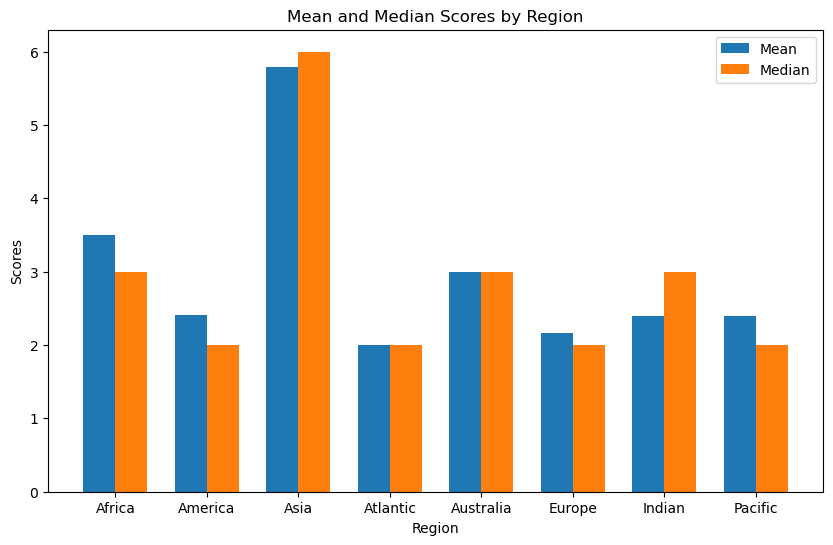

In [16]:
# Create a grouped bar chart
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
index = range(len(region_stats))

bar1 = ax.bar(index, region_stats['mean'], bar_width, label='Mean')
bar2 = ax.bar([i + bar_width for i in index], region_stats['median'], bar_width, label='Median')

ax.set_xlabel('Region')
ax.set_ylabel('Scores')
ax.set_title('Mean and Median Scores by Region')
ax.set_xticks([i + bar_width/2 for i in index])
ax.set_xticklabels(region_stats['Region'])
ax.legend()

plt.show()


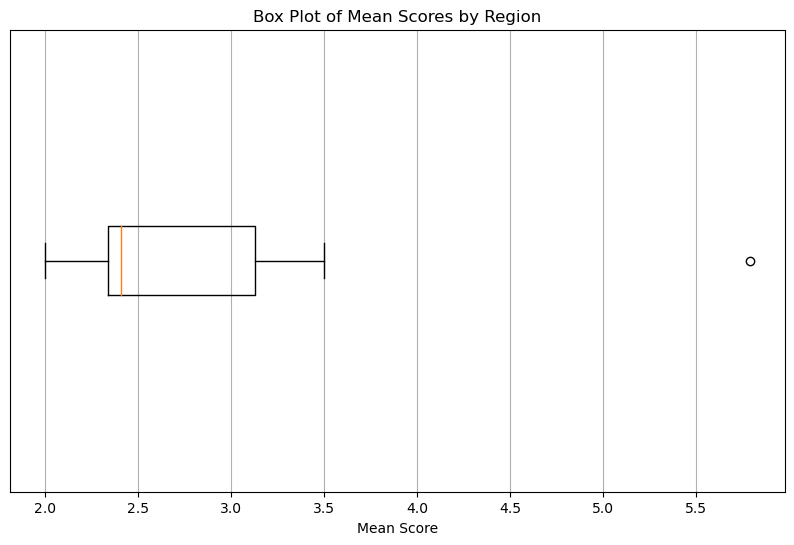

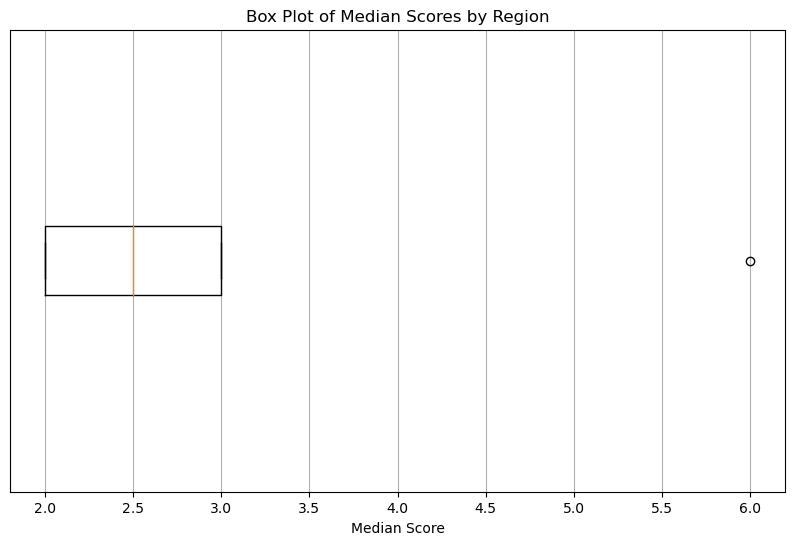

In [17]:

# Create a box plot for Mean scores by region
plt.figure(figsize=(10, 6))
plt.boxplot(region_stats['mean'], vert=False)
plt.title('Box Plot of Mean Scores by Region')
plt.xlabel('Mean Score')
plt.yticks([])  # Hide y-axis labels
plt.grid(axis='x')
plt.show()

# Create a box plot for Median scores by region
plt.figure(figsize=(10, 6))
plt.boxplot(region_stats['median'], vert=False)
plt.title('Box Plot of Median Scores by Region')
plt.xlabel('Median Score')
plt.yticks([])  # Hide y-axis labels
plt.grid(axis='x')
plt.show()
